# Deep Learning Model Analysis

This notebook contains three sections which analyse the data and models trained in the *model_training.ipynb* notebook:

+ In section [1. Load data and model](#1ma) the data and trained model of the ePodium and the DDP dataset are loaded.
+ In section [2. Make predictions on test set](#2ma) the loaded model is used to make predictions on the test set. 
+ In section [3. Show results](#3ma) the loss of the test set is calculated and the predictions are plotted in a scatterplot.

#### Import Packages
Note: This notebook may output tensorflow errors if cuda is not properly installed. The notebook still functions with these errors.

In [1]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import ipywidgets
import tensorflow as tf
from IPython.display import clear_output

# Local
import local_paths
from functions import epodium, display_helper, processing
from functions.epodium import Epodium
from functions.ddp import DDP
from functions.sequences import EpodiumSequence, DDPSequence

# Models
from models.dl_4_tsc import encoder_model, fully_convolutional_model, resnet_model
from models.eeg_dl import transformer_model

2022-11-10 00:31:20.513484: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-10 00:31:20.513528: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



---
<br>

<a id="1ma"></a>
### 1. Load data and model

Choose the DDP or ePodium dataset to make predictions on:

In [2]:
def choose_dataset(dataset_name):
    global labels, dataset
    if dataset_name == "epodium":
        dataset = Epodium()
        labels = dataset.create_labels(local_paths.ePod_metadata)
    elif dataset_name == "ddp":
        dataset = DDP()
        directory_age_metadata = os.path.join(local_paths.DDP_metadata, "ages")
        labels = dataset.create_labels(local_paths.DDP_dataset, directory_age_metadata)

    print(f"Using dataset: {dataset_name}.")

# Widget settings
w_dataset_name = ipywidgets.RadioButtons(description='Dataset:', options=["ddp", "epodium"], value="ddp")
ui = ipywidgets.HBox([w_dataset_name])
out = ipywidgets.interactive_output(choose_dataset, {'dataset_name': w_dataset_name})
display(ui, out)

Output()

### Load a trained model
Choose from the trained models in the _local_paths.models_ folder.

In [55]:
# Required plot setting:
%matplotlib inline 

# history = []
                                       
def load_model(trained_model):
    try:
        base_path = os.path.join(local_paths.models, trained_model)
    except:
        print("No models found.")
        return
    path_history = os.path.join(base_path, "history.npy")
    path_model = os.path.join(base_path, "model")
    path_testset = os.path.join(base_path, "subsets", "test_set.txt")
    path_weights = os.path.join(base_path, "weights.h5")
    
    global model
    global testset
    global history

    # Load Model
    if(os.path.exists(path_model)):
        print(f"\nLoading Model: '{w_model_name.value}'.")

        # Loads the entire model from a folder:
        model = tf.keras.models.load_model(path_model)
        model.load_weights(path_weights)
        # Reads the test-set of the trained model and puts the experiment names into a list:
        testset = open(path_testset, "r").read().split()
        # Loads the training history dictionary:
        history = np.load(path_history, allow_pickle=True).item()        

        # Show Loss of Training History
        print(f"\nThe lowest validation loss is: {round(min(history['val_loss']), 3)} at epoch {np.argmin(history['val_loss'])}\n")
        if "age" in trained_model:
            xlim, ylim = [0,100], [0,150000]
        if "dyslexia" in trained_model:
            xlim, ylim = [0,100], [0,0.1]
        display_helper.show_plot(x=range(len(history['loss'])), 
                                 y=[history['loss'], history['val_loss']], 
                                 legend=["loss","validation loss"], 
                                 xlabel="epochs", ylabel="validation loss (MSE)", 
                                 title=f"Loss during training ({trained_model})",
                                 xlim=xlim, ylim=ylim)

    else: 
        print("The model is untrained.")

# Find all models in 'local_paths.models' 
all_trained_models = sorted(f for f in os.listdir(os.path.join(local_paths.models)) if not "." in f)
# models_dataset = [m for m in all_trained_models if w_dataset_name.value in m] 


# Widget for selecting the trained models
w_model_name = ipywidgets.RadioButtons(options=all_trained_models, description='Models:')
display(w_model_name)
out = ipywidgets.interactive_output(load_model, {'trained_model': w_model_name})
display(out)

RadioButtons(description='Models:', options=('ddp_encoder_age_1', 'ddp_encoder_age_2', 'ddp_encoder_age_3', 'd…

Output()

<br>

<a id='2ma'></a>
### 2. Make predictions on test set

The predictions are made by predicting the label of multiple ERPs generated from the same experiment. Each ERP is different, since a random subset of the total number of epochs is used for creating the ERPs.

+ *n_passthroughs* is the number of predictions made from the same experiment. A higher number takes longer to process but is more accurate.

In [ ]:
n_passthroughs = 10

results = []

# Transfer learning, get entire ePodium dataset as testset:
if w_dataset_name.value  == "epodium" and "ddp" in w_model_name.value:
    testset = processing.valid_experiments(dataset, local_paths.ePod_epochs_events, min_standards=180, min_deviants=80)

# For each experiment in the test-set
for i, experiment in enumerate(testset):
    # Set up relevant sequence (each experiment gets its own sequence)
    if w_dataset_name.value == "ddp":
        test_sequence = DDPSequence([experiment], labels, local_paths.DDP_epochs, batch_size=1, n_instances_per_experiment=n_passthroughs, n_trials_averaged=60, mismatch_negativity=True)
    elif w_dataset_name.value  == "epodium":        
        if  "ddp" in w_model_name.value:
            epochs_directory = os.path.join(local_paths.ePod, "epochs_fif_500Hz_26ch")
            test_sequence = EpodiumSequence([experiment], labels, epochs_directory, 
                                            batch_size=n_passthroughs, label='age',
                                            n_trials_averaged=30)
        else:
            test_sequence = EpodiumSequence([experiment], labels, local_paths.ePod_epochs,
                                            batch_size=n_passthroughs, label='dyslexia', 
                                            n_trials_averaged=15, input_type="MMR") 

    # Get experiment
    x, y = test_sequence.__getitem__(0)
    
    # Make a prediction with the model.
    real_pred = [y[0], np.squeeze(model.predict(x, verbose=0)).mean()]
    results.append(real_pred)
    
    print(f"{i+1}/{len(testset)} predicted.")
    clear_output(wait=True)
    
results = np.array(results)

111/186 predicted.


#### Load and Save model predictions

*results* is a 2D numpy array that contains the real and predicted values of the samples in *results[0]* and *results[1]*.

In [162]:
predictions_path = os.path.join(local_paths.models, w_model_name.value, "predictions_age_"+w_dataset_name.value+".txt")

if os.path.exists(predictions_path):
    results = np.loadtxt(predictions_path)
    print(f"Results loaded from: {predictions_path}")
elif len(results) == len(testset):
    np.savetxt(predictions_path, results)
    print(f"Results saved to: {predictions_path}")
else:
    print(f"Could not save or load from {predictions_path}")

Results loaded from: /home/fpauwels/eegyolk/floris_files/models/trained_models/ddp_encoder_age_no_std/predictions_age_epodium.txt


<br>

<a id='3ma'></a>
### 3. Show results

#### Calculate test loss

The *Root Mean Square Error* (RMSE) is used to compare the different models

In [17]:
error = np.diff(results)
squared_error = np.square(error)
mean_squared_error = np.average(squared_error)
root_mean_squared_error = np.sqrt(mean_squared_error)
root_mean_squared_error

163.7749498710399

The *Mean Absolute Error* (MAE) is used to compare the different models

In [18]:
absolute_error = np.absolute(error)
mean_absolute_error = np.average(absolute_error)
mean_absolute_error

148.07261871009746

#### Scatterplot results ages 

In [ ]:
# Optional: color of dots depend on estimated amount of noise in data
testset = processing.valid_experiments(dataset, local_paths.ePod_epochs_events, min_standards=180, min_deviants=80)

standard_id = [2, 5, 8, 11]
list_n_standards = []

for experiment in testset:
    events_path = os.path.join(local_paths.ePod_epochs_events, experiment + '_events.txt')
    events = np.loadtxt(events_path, dtype=int)
    
    n_standards = 0    
    for i in range(4):
        n_standards += np.count_nonzero(events == standard_id[i])
    list_n_standards.append(n_standards)
color = (np.array(list_n_standards) - 800) / (max(list_n_standards) - 800)

[0.57336957 0.6576087  0.55570652 0.86820652 0.7173913  0.75951087
 0.86956522 0.85869565 0.86956522 0.85733696 0.81929348 0.86277174
 0.78940217 0.70516304 0.83695652 0.84375    0.83559783 0.63586957
 0.86956522 0.86820652 0.86277174 0.65217391 0.86684783 0.85461957
 0.77853261 0.77038043 0.86413043 0.86005435 0.70923913 0.83831522
 0.82065217 0.78804348 0.80842391 0.85190217 0.86820652 0.86820652
 0.61277174 0.86956522 0.80570652 0.81657609 0.80027174 0.75271739
 0.86956522 0.86956522 0.61684783 0.49728261 0.5326087  0.86820652
 0.74320652 0.81929348 0.86684783 0.86684783 0.86956522 0.86956522
 0.79755435 0.71875    0.76222826 0.83559783 0.80706522 0.86820652
 0.86956522 0.86548913 0.76902174 0.74728261 0.66711957 0.45244565
 0.82336957 0.85054348 0.78532609 0.80842391 0.84375    0.86956522
 0.85733696 0.86956522 0.86820652 0.86956522 0.77581522 0.63179348
 0.83152174 0.69701087 0.86956522 0.58288043 0.85326087 0.7513587
 0.53532609 0.79076087 0.86956522 0.93342391 0.8111413  0.83559

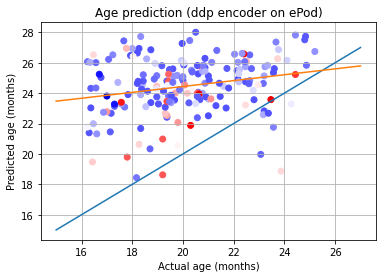

The correlation coefficient is: 0.232


In [161]:
# Calculate color (testset)

model_info = w_model_name.value.split("_")

ages_real = np.array(results)[:,0]/30
ages_predicted = np.array(results)[:,1]/30

display_helper.show_plot(ages_real, 
                         ages_predicted, 
                         f"Age prediction ({model_info[0]} {model_info[1]} on ePod)", 
                         "Actual age (months)",
                         "Predicted age (months)",
                         scatter=True,
                         scatter_color=color
                         show=False)
plt.grid()

if w_dataset_name.value == "ddp":
    x, y = 5, 50
elif w_dataset_name.value  == "epodium":
    x, y = 15, 27

# Line where predicted=actual:
plt.plot([x, y], [x, y]) 

m, c = np.polyfit(ages_real, ages_predicted, 1)
plt.plot([x, y], [x*m+c, y*m+c]) 
plt.show()

print(f"The correlation coefficient is: {round(np.corrcoef(ages_real, ages_predicted)[0, 1], 3)}" )

#### Scatterplot results risk of dyslexia 

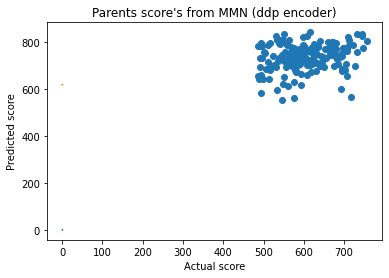

In [128]:
model_info = w_model_name.value.split("_")

risk_real = np.array(results)[:,0]
risk_predicted = np.array(results)[:,1]

display_helper.show_plot(risk_real, 
                         risk_predicted, 
                         f"Parents score's from MMN ({model_info[0]} {model_info[1]})", 
                         "Actual score",
                         "Predicted score",
                         scatter=True,
                         show=False)
x, y = 0.3, 1
plt.plot([x, y], [x, y]) 

m, c = np.polyfit(risk_real, risk_predicted, 1)
plt.plot([x, y], [x*m+c, y*m+c]) 
plt.show()

In [28]:
import glob
import mne
# Save dataset in different dimension (sampling_rate, channels)
sample_rate=501
channels=dataset.channels_epod_ddp

# Loop over each epochs_fif file
experiment_paths = glob.glob(os.path.join(local_paths.ePod_epochs, '*.fif'))
for experiment_path in experiment_paths:
    path_epochs_ddp_dims = os.path.join(local_paths.ePod, "epochs_fif_500Hz_26ch", experiment + "_epo.fif")
    if os.path.exists(path_epochs_ddp_dims):
        continue
        
    filename_events = os.path.basename(experiment_path)
    experiment = filename_events.split(("_epo.fif"))[0]
    
    # Load and modify epochs
    print(f"Modifying experiment {experiment}")
    path_epochs = os.path.join(local_paths.ePod_epochs, experiment + "_epo.fif")
    epochs = mne.read_epochs(path_epochs, verbose=0)
    epochs.pick_channels(dataset.channels_epod_ddp)
    epochs.resample(sample_rate)
    
    # Save epochs with new dimensions
    epochs.save(path_epochs_ddp_dims)   

In [ ]:
# Tool to calculate mean score
array = np.array(labels["Dyslexia_score"])-0.68
square = np.square(array)
np.average(square)


<function matplotlib.pyplot.show(close=None, block=None)>

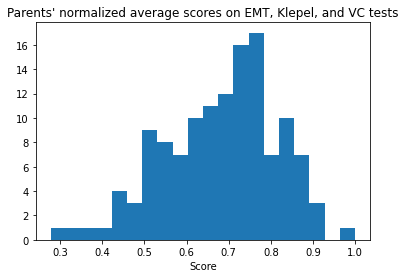

In [53]:
plt.hist(labels["Dyslexia_score"], bins=20)
plt.title('Parents\' normalized average scores on EMT, Klepel, and VC tests')
plt.xlabel('Score')
#plt.ylabel('')
plt.show


In [62]:
predictions_path = os.path.join(local_paths.models, "clean_epod_experiments.txt")
np.savetxt(predictions_path, np.array(testset), fmt='%s')

'229a'

Analyzed: 248 bad: 62
186 experiments have enough epochs for analysis.


In [131]:
color=color-0.5

In [146]:
color

array([0.57336957, 0.6576087 , 0.55570652, 0.86820652, 0.7173913 ,
       0.75951087, 0.86956522, 0.85869565, 0.86956522, 0.85733696,
       0.81929348, 0.86277174, 0.78940217, 0.70516304, 0.83695652,
       0.84375   , 0.83559783, 0.63586957, 0.86956522, 0.86820652,
       0.86277174, 0.65217391, 0.86684783, 0.85461957, 0.77853261,
       0.77038043, 0.86413043, 0.86005435, 0.70923913, 0.83831522,
       0.82065217, 0.78804348, 0.80842391, 0.85190217, 0.86820652,
       0.86820652, 0.61277174, 0.86956522, 0.80570652, 0.81657609,
       0.80027174, 0.75271739, 0.86956522, 0.86956522, 0.61684783,
       0.49728261, 0.5326087 , 0.86820652, 0.74320652, 0.81929348,
       0.86684783, 0.86684783, 0.86956522, 0.86956522, 0.79755435,
       0.71875   , 0.76222826, 0.83559783, 0.80706522, 0.86820652,
       0.86956522, 0.86548913, 0.76902174, 0.74728261, 0.66711957,
       0.45244565, 0.82336957, 0.85054348, 0.78532609, 0.80842391,
       0.84375   , 0.86956522, 0.85733696, 0.86956522, 0.86820